# multi-class tweets classification

## 1. pytorch - LSTM introduction

<img src="image/pytorch_LSTM_1.png" width="550">

### 1.1 LSTM architecture
> **model = nn.LSTM(input_size, hidden_size, num_layers, bias, batch_first, dropout, bidirectional)**
1. input_size: 每个单词的 embedding or one-hot encoding 的尺寸，例如：glove 300d。
2. hidden_size: 隐含层神经元的个数，例如上图的n。
3. num_layers: LSTM的层数，例如上图的层数为1。
4. bias: default true。
5. batch_first: 
6. dropout: 0-1
7. bidirectional: true or false.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

lstm = nn.LSTM(100, 3, 2)  # word embedding size is 300, hidden layer size is 3, two LSTM layer. 
print(lstm.all_weights[0][0].shape)
print(lstm.all_weights[0][1].shape)
print(lstm.all_weights[0][2].shape)
print(lstm.all_weights[0][3].shape)

torch.Size([12, 100])
torch.Size([12, 3])
torch.Size([12])
torch.Size([12])


### 1.2 LSTM input and output
><img src="image/pytorch_LSTM.png" width="500">
>
>**output, ($\text{h}_n$, $\text{c}_n$) = model(input, ($\text{h}_0$, $\text{c}_0$))**
>
>* input维度：(句子长度, batch_size（一次多少个句子）, input_size（每个单词向量的长度）) 。
>* $\text{h}_0, \text{c}_0$维度：(num_layers * num_directions, batch, hidden_size)。例如，上图有w+1层，单向，hidden_size为每个LSTM结构内隐含层神经元个数。 


In [2]:
inputs = [torch.randn(1, 100) for _ in range(5)] # In a sentence, 5 words, every words' length is 4.

hidden = (torch.randn(2*1, 1, 3), torch.randn(2*1, 1, 3)) # h_0, c_0.

for i in inputs:
    out, hidden = lstm(i.view(1, 1, -1), hidden)

print("1. sentence length: ",len(inputs)," word embedding:",inputs[0].shape)
print("2. input is every word in sentence: ", i.view(1, 1, -1).shape)
print("3. output size: ", out.shape)
print("4. h_1 size: ", hidden[0].shape)
print("5. c_1 size: ", hidden[1].shape)

1. sentence length:  5  word embedding: torch.Size([1, 100])
2. input is every word in sentence:  torch.Size([1, 1, 100])
3. output size:  torch.Size([1, 1, 3])
4. h_1 size:  torch.Size([2, 1, 3])
5. c_1 size:  torch.Size([2, 1, 3])


### 1.3 forward pass
>**module(data) = module.forward(data)**
>
><img src="image/forward.png" width="550">

### 1.4 handle input with variable length
>* torch.nn.utils.rnn.pad_sequence()：把不等长的tensor数据, 补充成等长的tensor数据.
* torch.nn.utils.rnn.pack_padded_sequence()：把等长的tensor根据所输入的参数压缩成实际的数据, 同时数据格式变成PackedSequence。
* torch.nn.utils.rnn.pad_packed_sequence()：把上面所压缩成PackedSequence的数据还原成tensor类型, 并补成等长的数据。

https://blog.csdn.net/kejizuiqianfang/article/details/100835528

### 1.5 pytorch loss function for classification
>
>* nn.Softmax and nn.LogSoftmax: 
* nn.NLLLoss: negative log likelihood loss. 
* nn.CrossEntropy: the combination of nn.Softmax and nn.NLLLoss.
* nn.BCELoss: *bianry* classification loss. 

## 2. bi-directional GRU for priority

In [3]:
# load pre-processed dataset.
import pandas as pd
import json
import torch   
from torchtext import data 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import os
from torchtext.vocab import Vectors
import torch.nn as nn
import torch.optim as optim

### 2.1 dataset processing in pytorch

In [4]:
# notice dataset is extremely unbalanced.
dataset = pd.read_csv("pre-processed data/dataset_aug_priority.csv", usecols=['content','priority'])

dataset[:5]

,priority,content
0,Medium,pagasa advisory red warning metro manila heavy...
1,Medium,pagasa advisory red warning metro manila heavy...
2,Medium,pagasa advisory red warning metro manila heavy...
3,Medium,pagasa advisory red warning metro manila heavy...
4,Medium,flood alert san marcelino taft ayala manila pa...


In [5]:
torch.manual_seed(2020)

# loading custom dataset
TEXT = data.Field(tokenize=lambda x: x.split() ,batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)

fields = [('priority', LABEL), ('content', TEXT)]

dataset=data.TabularDataset(path = 'pre-processed data/dataset_aug_priority.csv',format = 'csv',fields = fields,skip_header = True)

print(vars(dataset.examples[0]))

{'priority': 'Medium', 'content': ['pagasa', 'advisory', 'red', 'warning', 'metro', 'manila', 'heavy', 'intense', 'rain', 'next', 'hr', 'flood', 'low', 'lie', 'area', 'near', 'river']}


In [6]:
tr_X, te_X = dataset.split(split_ratio=0.8, random_state = random.seed(2020))
tr_x, val_x = tr_X.split(split_ratio=0.7, random_state = random.seed(2020))

# load downloaded glove word embedding.
cache = '.vector_cache'
if not os.path.exists(cache): os.mkdir(cache)
vectors = Vectors(name='./glove.840B.300d.txt', cache=cache)

# create vocab.
TEXT.build_vocab(tr_X, min_freq=3, vectors=vectors)
LABEL.build_vocab(tr_X)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

print("Size of LABEL vocabulary:",len(LABEL.vocab))

print("Top words: ", TEXT.vocab.freqs.most_common(5))  

# Word dictionary.
print("LABEL vocabulary: ", LABEL.vocab.stoi)

Size of TEXT vocabulary: 7994
Size of LABEL vocabulary: 4
Top words:  [('shoot', 3638), ('flood', 3344), ('school', 3198), ('people', 2834), ('after', 2709)]
LABEL vocabulary:  defaultdict(None, {'Medium': 0, 'High': 1, 'Critical': 2, 'Unknown': 3})


### 2.2 Architecture

<img src="image/architecture.png" width="400">

In [7]:
class RNN_classifier(nn.Module):
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # bi-directional LSTM
        self.lstm = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)

        # dense layer
        self.fc = nn.Linear(hidden_dim*2, 64)
        
        self.fc1 = nn.Linear(64, output_dim)

        # don't need activation function if using nn.CrossEntropy
    
    def forward(self, text, text_lengths):
        
        # text word index.
        embedded = self.embedding(text) # shape = [batch, length, word embedding]
        
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)

        packed_output, hidden = self.lstm(packed_embedded) # GRU has two outputs, LSTM has three. eg. packed_output, (hidden, cell)
        
        # hidden shape [2, 64, num_hidden_nodes] if LSTM shape [1, 64, num_hidden_nodes]
        # concat the final forward and backward hidden state (use hidden state, not output)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        #hidden = [batch size, hid dim * num directions]
        hidden_outputs = self.fc(hidden)
        
        dense_outputs = self.fc1(F.relu(hidden_outputs))
        
        #Final activation function
        # outputs=self.act(dense_outputs)
        
        return dense_outputs

### 2.3 training and evaluate function

In [8]:
def train(model, iterator, optimizer, criterion):
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        cont, cont_lengths = batch.content 

        # forward
        predictions = model(cont, cont_lengths).squeeze()  

        #compute the loss
        loss = criterion(predictions, batch.priority.long())  
        
        # backward
        loss.backward()       
        
        #update the weights
        optimizer.step() 
        
        #loss and accuracy
        epoch_loss += loss.item()     
        
    return epoch_loss / len(iterator)

In [9]:
def evaluate(model, iterator, criterion):
    label_list, preds_list = [], []
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
            
            # retrieve text and length
            cont, cont_lengths = batch.content 

            predictions = model(cont, cont_lengths).squeeze()
            
            # keep result
            preds_list.extend(list(np.array(torch.max(predictions, 1)[1].numpy(), dtype=int)))
            label_list.extend(list(np.array(batch.priority.numpy(), dtype=int)))

            # compute loss and accuracy
            loss = criterion(predictions, batch.priority.long())
            
            # train loss.
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), preds_list, label_list

In [10]:
size_of_vocab = len(TEXT.vocab)


def SGD(tr_x, val_x, n_epoches=100, lr = 0.001, dropout = 0.3, batch_size = 32, num_hidden_nodes = 32):
    
    train_loss_list, valid_loss_list = [], []
    
    embedding_dim = 300
    num_output_nodes = 5
    num_layers = 1 # depth
    bidirection = True
    
    # GPU or CPU.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    
    # Load an iterator
    train_iterator, valid_iterator = data.BucketIterator.splits((tr_x, val_x), 
                                                                batch_size = batch_size,
                                                                sort_key = lambda x: len(x.content),
                                                                sort_within_batch=True,
                                                                device=device)



    # model print(model)
    model = RNN_classifier(size_of_vocab, embedding_dim, 
                       num_hidden_nodes,num_output_nodes, 
                       num_layers, bidirectional = True, 
                       dropout = dropout)
    
    # pre-trained Glove.
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    
    # define optimizer and loss.
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-8)
    criterion = nn.CrossEntropyLoss()
    
    # training
    for epoch in range(n_epoches):

        #train the model
        train_loss = train(model, train_iterator, optimizer, criterion)

        #evaluate the model
        valid_loss, preds_list, label_list = evaluate(model, valid_iterator, criterion)
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        
        print(f"Epoch: {epoch:d} : Train Loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f}")
        
        #if (len(valid_loss_list) >= 2):
        #    if (valid_loss_list[-2] - valid_loss_list[-1]) < 0.001: break
        
    return train_loss_list, valid_loss_list, preds_list, label_list

### 2.4 hyper-parameter choosing

In [11]:
# for hn in [10, 20, 40, 100]:
#     for lr in [0.001, 0.01, 0.1]:
#         print("hidden layer nodes: ", hn, ", learning rate: ", lr)
#         train_loss, valid_loss = SGD(tr_x, val_x, 
#                                      n_epoches=50, lr=lr, 
#                                      dropout=0, batch_size = 64, 
#                                      num_hidden_nodes = hn)

In [18]:
train_loss, valid_loss, preds_list, label_list = SGD(tr_X, te_X, 
                             n_epoches=200, 
                             lr=0.007, 
                             dropout=0.2, 
                             batch_size = 64, 
                             num_hidden_nodes = 50)

Epoch: 0 : Train Loss: 1.2409 | Valid loss: 1.1040
Epoch: 1 : Train Loss: 1.0826 | Valid loss: 1.0720
Epoch: 2 : Train Loss: 1.0636 | Valid loss: 1.0570
Epoch: 3 : Train Loss: 1.0497 | Valid loss: 1.0419
Epoch: 4 : Train Loss: 1.0327 | Valid loss: 1.0231
Epoch: 5 : Train Loss: 1.0113 | Valid loss: 0.9993
Epoch: 6 : Train Loss: 0.9876 | Valid loss: 0.9761
Epoch: 7 : Train Loss: 0.9651 | Valid loss: 0.9539
Epoch: 8 : Train Loss: 0.9453 | Valid loss: 0.9350
Epoch: 9 : Train Loss: 0.9268 | Valid loss: 0.9206
Epoch: 10 : Train Loss: 0.9100 | Valid loss: 0.9021
Epoch: 11 : Train Loss: 0.8933 | Valid loss: 0.8879
Epoch: 12 : Train Loss: 0.8772 | Valid loss: 0.8718
Epoch: 13 : Train Loss: 0.8611 | Valid loss: 0.8535
Epoch: 14 : Train Loss: 0.8449 | Valid loss: 0.8383
Epoch: 15 : Train Loss: 0.8279 | Valid loss: 0.8228
Epoch: 16 : Train Loss: 0.8116 | Valid loss: 0.8059
Epoch: 17 : Train Loss: 0.7952 | Valid loss: 0.7905
Epoch: 18 : Train Loss: 0.7780 | Valid loss: 0.7744
Epoch: 19 : Train Loss

Epoch: 157 : Train Loss: 0.0535 | Valid loss: 0.2320
Epoch: 158 : Train Loss: 0.0506 | Valid loss: 0.2145
Epoch: 159 : Train Loss: 0.0797 | Valid loss: 0.2174
Epoch: 160 : Train Loss: 0.0509 | Valid loss: 0.2162
Epoch: 161 : Train Loss: 0.0498 | Valid loss: 0.2181
Epoch: 162 : Train Loss: 0.0489 | Valid loss: 0.2223
Epoch: 163 : Train Loss: 0.0670 | Valid loss: 0.2138
Epoch: 164 : Train Loss: 0.0477 | Valid loss: 0.2137
Epoch: 165 : Train Loss: 0.0466 | Valid loss: 0.2189
Epoch: 166 : Train Loss: 0.0463 | Valid loss: 0.2714
Epoch: 167 : Train Loss: 0.0474 | Valid loss: 0.2130
Epoch: 168 : Train Loss: 0.0470 | Valid loss: 0.2303
Epoch: 169 : Train Loss: 0.0470 | Valid loss: 0.2114
Epoch: 170 : Train Loss: 0.0455 | Valid loss: 0.2214
Epoch: 171 : Train Loss: 0.0537 | Valid loss: 0.2143
Epoch: 172 : Train Loss: 0.0475 | Valid loss: 0.2241
Epoch: 173 : Train Loss: 0.0447 | Valid loss: 0.2119
Epoch: 174 : Train Loss: 0.0449 | Valid loss: 0.2847
Epoch: 175 : Train Loss: 0.0459 | Valid loss: 

### 2.5 Result:

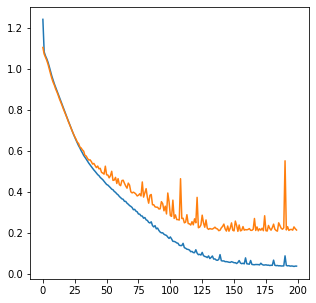

In [19]:
epoch = [i for i in range(len(train_loss))]

plt.figure(figsize=(5,5))
plt.plot(epoch, train_loss)
plt.plot(epoch, valid_loss)
plt.show()

In [20]:
Y_te = label_list
preds_te = preds_list

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.9379092609915809
Precision: 0.9408597034355329
Recall: 0.9409344702808645
F1-Score: 0.9408604905562413


### Conclusion:
>1. choose SGD rather than Adam.
>2. using nn.CrossEntropyLoss() (nn.logSoftmax() + nn.NLLLoss()) for multi-class classification.

tutorial: https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/